In [191]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import xgboost as xgb

In [173]:
companies = [
    "SAP", "IBM", "WDAY", "ADP", "ACN",  # Technology
    "NXPI", "STM", "ADI", "ON", "MCHP", "LSCC", "COHR", "AEIS", "ENTG",  # Semiconductors & Software
    "BX", "KKR", "STT", "AMP", "PNC", "CFG", "BK", "NTRS", "FITB",  # Financials
    "UL", "PDD", "JD", "BABA", "SBUX", "YUM", "ROST", "M", "KSS",  # Consumer Discretionary & Retail
    "ZTS", "DHR", "BDX", "SYK", "BSX", "STE", "MTD", "BIO",  # Healthcare
    "TAP", "KMB", "GIS", "HRL", "MDLZ", "LW", "MNST",  # Consumer Staples
]


In [174]:
data = pd.DataFrame()

In [178]:
for i in companies:
    try:

        curr = yf.download(i, start='2014-10-15', end='2024-10-26')

        curr = curr.reset_index()

        curr.columns = [col[0] for col in curr.columns]

        curr.drop(columns=['Date'], inplace=True)
        empty_data = pd.DataFrame()
        result_df = calculate_tech_ind(curr, empty_data)
        data = pd.concat([data, result_df], ignore_index=True)

    except Exception as e:
        print(e, i)

[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_41260\1258870705.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values
[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_41260\1258870705.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] 

In [177]:
def calculate_tech_ind(curr, data):

    data['SMA15'] = ta.sma(curr['Close'], length=15)  # Simple Moving Average
    data['EMA5'] = ta.ema(curr['Close'], length=5)    # Exponential Moving Average
    data['RSI15'] = ta.rsi(curr['Close'], length=15)  # Relative Strength Index

    # Bollinger Bands: Measures volatility with a moving average and standard deviations
    data['BB_upper'], data['BB_lower'] = ta.bbands(curr['Close'], length=56, std=2).iloc[:, [0, 2]].T.values

    # MACD and Signal Line: Trend-following momentum indicator
    data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values

    # On-Balance Volume: Volume-based trend indicator
    data['OBV'] = ta.obv(curr['Close'], curr['Volume'])

    # ADX (Average Directional Index): Measures trend strength
    data['ADX'] = ta.adx(curr['High'], curr['Low'], curr['Close']).iloc[:, 0]

    # Aroon Oscillator: Identifies trend direction and strength
    data['Aroon_Up'], data['Aroon_Down'] = ta.aroon(curr['High'], curr['Low']).iloc[:, [0, 1]].T.values
    
    uncleaned_data = pd.concat([curr, data], axis = 0)

    uncleaned_data = uncleaned_data.iloc[14:, :]

    uncleaned_data.fillna(method='ffill', inplace=True)

    uncleaned_data.fillna(method='bfill', inplace=True)

    scaled_data = scale_data(uncleaned_data)

    result_df = final_pcas(scaled_data)

    return result_df

In [176]:
def scale_data(uncscaled_data):
       price_columns = ['Open', 'High', 'Low', 'Close']
       technical_indicators = ['SMA15', 'EMA5',
              'RSI15', 'BB_upper', 'BB_lower', 'MACD', 'MACD_signal', 'OBV', 'ADX',
              'Aroon_Up', 'Aroon_Down']
       volume_column = 'Volume'

       min_max_scaler = MinMaxScaler()
       standard_scaler = StandardScaler()

       uncscaled_data[price_columns] = min_max_scaler.fit_transform(uncscaled_data[price_columns])

       uncscaled_data[volume_column] = np.log1p(uncscaled_data[volume_column])  
       uncscaled_data[[volume_column]] = min_max_scaler.fit_transform(uncscaled_data[[volume_column]])

       uncscaled_data[technical_indicators] = standard_scaler.fit_transform(uncscaled_data[technical_indicators])

       return uncscaled_data



In [175]:
def final_pcas(data):
    feature_columns = ['Open', 'High', 'Low', 'SMA15', 'EMA5',
            'RSI15', 'BB_upper', 'BB_lower', 'OBV', 'ADX',
            'Aroon_Up', 'Aroon_Down']

    X = data[feature_columns]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=8)  
    X_pca = pca.fit_transform(X_scaled)

    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)


    n_components_to_keep = np.argmax(cumulative_variance >= 0.90) 
    pca_final = PCA(n_components=n_components_to_keep)
    X_final = pca_final.fit_transform(X_scaled)

    pca_columns = [f'PC{i+1}' for i in range(n_components_to_keep)]
    pca_df = pd.DataFrame(data=X_final, columns=pca_columns)
    data = pd.DataFrame(data=data, columns=['MACD', 'MACD_signal', 'Close'])
    result_df = pd.concat([data.reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)

    return result_df


In [179]:
input = data
target = data['Close']
input.drop(columns=['Close'], inplace=True)

In [180]:
input.drop(columns=['PC3', 'PC4'], inplace=True)

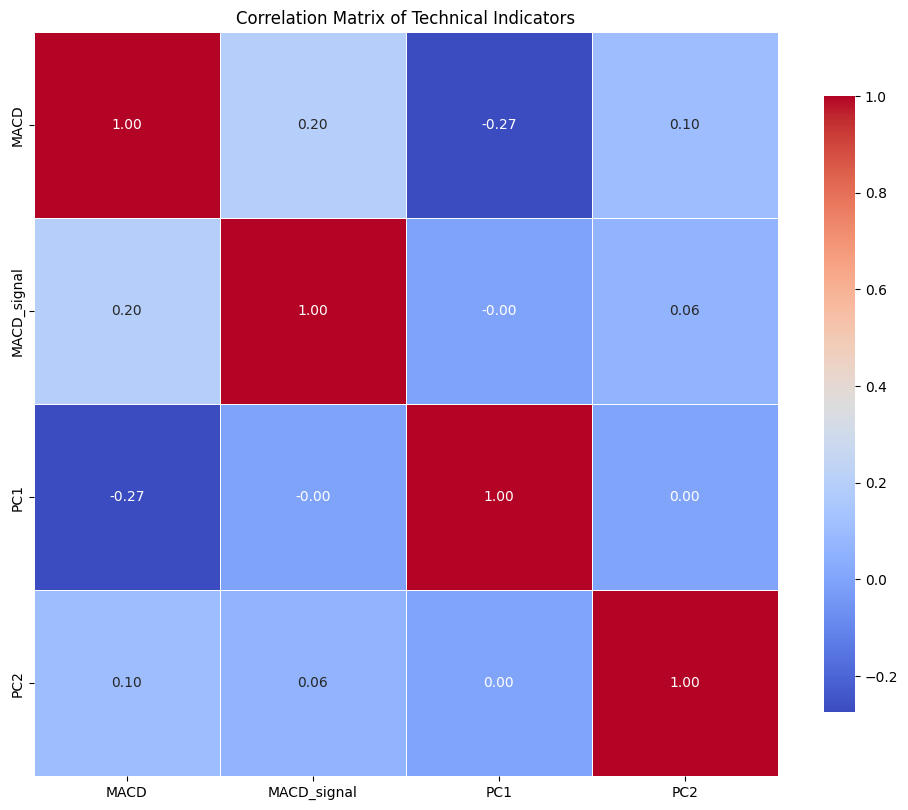

In [181]:
correlation_matrix = input.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, cbar_kws={"shrink": .8}, linewidths=.5)

# Title and show the plot
plt.title('Correlation Matrix of Technical Indicators')
plt.show()


In [182]:
model_dl = keras.models.load_model('dl_model')

In [183]:
y_new_pred = model_dl.predict(input)
new_results = pd.DataFrame({
    'Predicted': y_new_pred.flatten()  # Adjust as needed
})


7305/7305 [==============================] - 17s 2ms/step


In [186]:
new_results

,Predicted
0,0.098949
1,0.099802
2,0.100880
3,0.098078
4,0.099667
...,...
233739,0.898898
233740,0.892025
233741,0.875841
233742,0.853774


In [192]:
r2 = r2_score(target, y_new_pred)
print(f'R-squared: {r2:.2f}')


R-squared: 0.44


In [168]:
loaded_model = xgb.XGBRegressor()  
loaded_model.load_model('regression_model_new.json')  

In [169]:
y_pred = loaded_model.predict(input)

# Evaluate the model performance
mse = mean_squared_error(data['Close'], y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Optional: Calculate R-squared
r2 = loaded_model.score(input, data['Close'])
print(f'R-squared: {r2}')

print('\n ', y_pred, '\n', data['Close'].iloc[-1])

Mean Squared Error: 0.0022185655072874295
Root Mean Squared Error (RMSE): 0.04710165079153203
R-squared: 0.9738125636176193

  [-2.3528638e-03 -5.6870235e-04 -1.2103259e-03 ...  8.0327117e-01
  8.0947131e-01  7.9708910e-01] 
 0.8312337865856028


In [170]:
results = pd.DataFrame({
    'Actual': data['Close'],
    'Predicted': y_pred
})

print(results.sample())

          Actual  Predicted
189074  0.849183   0.827513


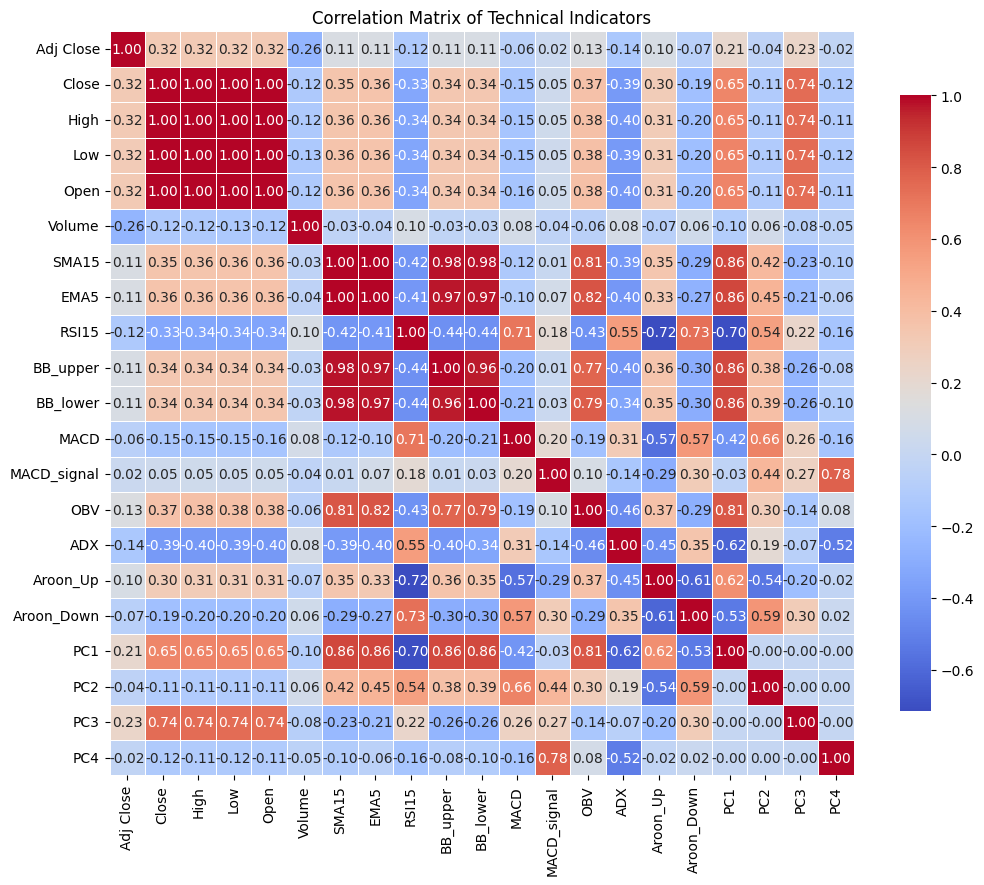

In [171]:


# Calculate the correlation matrix
correlation_matrix = result_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, cbar_kws={"shrink": .8}, linewidths=.5)

# Title and show the plot
plt.title('Correlation Matrix of Technical Indicators')
plt.show()
